In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

### Загрузим датасет с машинами. Цель - верно восстанавливать для каждой из них цену продажи!

In [61]:
data = pd.read_csv('autos.csv')

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [62]:
### Колонка с тергетом - "selling price"

X = data.drop("selling_price", axis=1)
y = data["selling_price"]

### Будем замерять MSLE!
### Поэтому прологарифмируем таргет
### А после оптимизируем MSE

y = y.apply(np.log1p)

In [63]:
X.shape

(4340, 7)

In [64]:
### Разделим выборку на трейн и тест!

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

__Задание__ 

Реализуйте свой MeanTargetEncoder с добавленем некоторого шума!

Однажды в лекционном материале, обсуждая счетчики, мы говорили с вами о том, что из-за них модели могут переобучаться. Один из способов бороться с этим - валидировать расчеты среднего таргета (стратегия отложенной выборки / расчеты на кросс-валидации). Но есть еще проще!

Можно просто к значению счетчика добавить случайный шум (зашумить данные)!

Напомним, что рассчитываться новые признаки должны по такой формуле:

$$
g_j = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}{l} + C * \epsilon
$$


Пусть шум будет случайной величиной из нормального стандартного распределения, то есть $\epsilon \sim N(0, 1) $, а $ C = 0.006$.

Создавай свой класс-трансформер, наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`. Трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. 
Ваш трансформер должен принимать при инициализации список из категориальных признаков и список из числовых признаков. 

Если для какого-то признака в тестовой выборке отсутствует значение, трансформер должен поставить там 0.

На выходе должен получиться датасет того же размера с измененными категориальными признаками

In [65]:
object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

X.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner


In [77]:
from sklearn.base import BaseEstimator, TransformerMixin
from numpy.random import normal
import itertools

class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):
    
    def __init__(self, object_columns=[], numeric_columns=[]):
        
        self.object_columns = object_columns
        self.numeric_columns = numeric_columns
    
    def fit(self, X, y):

        ### Your code is here
        X_fit = X.copy()
        y_fit = y.copy()
        C = 0.006
        
        X_with_target = pd.concat((X_fit, y_fit), axis=1)
        self.target_name = y_fit.name
        
        ### Сгенерим колонки к которым применим One-Hot-Encoding
        self.cols_for_ohe = [col for col in self.object_columns
                             if 
                             X_with_target[col].nunique() <= 10]
        
        ### Запомним все ohe колонки и их названия!
        self.ohe_names = {col : sorted([f"{col}_{value}" for value in X_with_target[col].unique()])
                          for col in self.cols_for_ohe}
        
        
        ### Сгенерим колонки к которым применим Mean-Target-Encoding
        self.cols_for_mte = [col for col in self.object_columns
                             if X_with_target[col].nunique() > 10]
        # 
        ### Посчитаем на валидации средние значения таргета
        self.dict_of_means = {col: X_with_target.groupby(col)[self.target_name].mean() +  normal(0,1, X_with_target.groupby(col)[self.target_name].mean().count())*C
                              for col in self.cols_for_mte}
    
        return self
        
    def transform(self, X):
        
        ### Your code is here
        X_ = X.copy()
        
        
        data_part = pd.get_dummies(X_[self.cols_for_ohe],
                                   prefix=self.cols_for_ohe)
        
        data_part_cols = data_part.columns
        
        X_ = X_.drop(self.cols_for_ohe, axis=1)
        X_ = pd.concat((X_, data_part), axis=1)
        
        for col in self.cols_for_mte:
                X_[col] = X_[col].map(self.dict_of_means[col])
                
                mean_value = self.dict_of_means[col].values.mean()
                
                X_[col] = X_[col].fillna(0)
                
            
            
        all_ohe = list(itertools.chain(*list(self.ohe_names.values())))
        
        missing_columns = [x 
                           for x in all_ohe
                           if x not in X_.columns
                           and
                           x not in self.numeric_columns]

        extra_columns = [x
                         for x in data_part_cols
                         if x not in all_ohe]
        
        ### Новые категории необходимо убрать
        X_ = X_.drop(extra_columns, axis=1)
    
        ### Отсутствующие категории (бинарные колонки)
        ### необходимо добавить: заполним их просто нулями
        
        if len(missing_columns) != 0:

            zeros = np.zeros((X_.shape[0], len(missing_columns)))
            zeros = pd.DataFrame(zeros,
                                 columns=missing_columns,
                                 index=X_.index)

            X_ = pd.concat((X_, zeros), axis=1)
                 
        return X_[sorted(X_.columns)]

In [78]:
### Проверка работы трансформера

np.random.seed(1)
transformer = MeanTargetEncoderNoise(object_columns=object_cols, numeric_columns=num_cols)

transformer.fit(X_train, y_train)

train = transformer.transform(X_train)
test = transformer.transform(X_test)

train.head()

,fuel_CNG,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,km_driven,name,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,year
3294,0,1,0,0,0,50000,13.483692,1,0,0,0,0,0,1,0,1,0,13.436559
2290,0,0,0,0,1,70000,12.117029,1,0,0,0,0,0,1,0,1,0,11.903115
874,0,0,0,0,1,50000,12.310456,1,0,0,0,0,0,1,0,0,1,13.328864
1907,0,0,0,0,1,92198,12.491443,0,0,1,0,0,1,0,0,0,1,13.042359
3244,0,0,0,0,1,3240,12.390906,0,0,1,0,0,0,1,0,0,1,12.870886


Обучите несколько деревьев, перебирая максимальную глубину алгоритма из списка `max_depth_list`, а остальные параметры оставьте дефолтными. Выведите лучшее значение гиперпараметра. Постройте график зависимости MSLE на тестовой выборке от значения гиперпараметра. Воспользуйтесь `Pipeline` без `GridSearch`. Проделайте то же самое с `min_samples_split`, `min_impurity_decrease`, `max_leaf_nodes`. (по 2б на каждый параметр)

In [79]:
max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

In [80]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

np.random.seed(1)

### Your code is here
pipe = Pipeline([("transformer",
                  MeanTargetEncoderNoise(object_columns=object_cols, numeric_columns=num_cols)),        
                 ("decision_tree", 
                  DecisionTreeRegressor())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 MeanTargetEncoderNoise(numeric_columns=['km_driven'],
                                        object_columns=['name', 'year', 'fuel',
                                                        'seller_type',
                                                        'transmission',
                                                        'owner'])),
                ('decision_tree', DecisionTreeRegressor())])

0.798


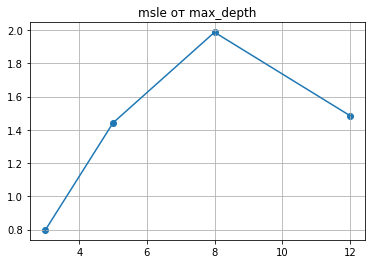

In [81]:
np.random.seed(1)
MSLE_depth_train = {}
MSLE_depth_test = {}
pipe.set_params(decision_tree__max_depth = None, decision_tree__min_samples_split=2, decision_tree__min_impurity_decrease=0.0, decision_tree__max_leaf_nodes=None)   
for d in max_depth_list:
    pipe.set_params(decision_tree__max_depth=d)
    pipe.fit(X_train, y_train)
    train_preds = pipe.predict(X_train)
    test_preds = pipe.predict(X_test)

#     train_error = np.mean((train_preds - y_train)**2)
#     test_error = np.mean((test_preds - y_test)**2)
    MSLE_depth_train[d] = np.round(mse(train_preds, y_train, squared=True), 3)
    MSLE_depth_test[d] = np.round(mse(test_preds, y_test, squared=True), 3)

    
#print(max(MSLE_depth_test, key=MSLE_depth_test.get))
print(min(MSLE_depth_test.values()))
plt.grid(True)
plt.title('msle от max_depth')
plt.scatter(MSLE_depth_test.keys(), MSLE_depth_test.values());
plt.plot(MSLE_depth_test.keys(), MSLE_depth_test.values());

0.808


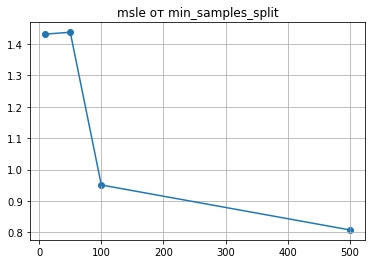

In [82]:
np.random.seed(1)
MSLE_samples_train = {}
MSLE_samples_test = {}
pipe.set_params(decision_tree__max_depth = None, decision_tree__min_samples_split=2, decision_tree__min_impurity_decrease=0.0, decision_tree__max_leaf_nodes=None)   
for d in min_samples_split_list:
    pipe.set_params(decision_tree__min_samples_split=d)
    pipe.fit(X_train, y_train)
    train_preds = pipe.predict(X_train)
    test_preds = pipe.predict(X_test)

    train_error = np.mean((train_preds - y_train)**2)
    test_error = np.mean((test_preds - y_test)**2)
    MSLE_samples_train[d] = np.round(train_error, 3)
    MSLE_samples_test[d] = np.round(test_error, 3)

print(min(MSLE_samples_test.values()))
plt.grid(True)
plt.title('msle от min_samples_split')
plt.scatter(MSLE_samples_test.keys(), MSLE_samples_test.values());
plt.plot(MSLE_samples_test.keys(), MSLE_samples_test.values());

0.52


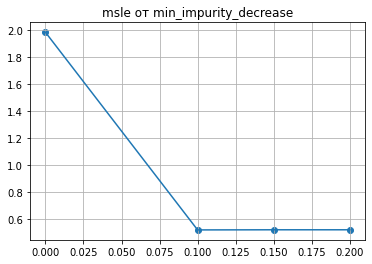

In [44]:
np.random.seed(1)
MSLE_decrease_train = {}
MSLE_decrease_test = {}
pipe.set_params(decision_tree__max_depth = None, decision_tree__min_samples_split=2, decision_tree__min_impurity_decrease=0.0, decision_tree__max_leaf_nodes=None)   
for d in min_impurity_decrease_list:
    pipe.set_params(decision_tree__min_impurity_decrease=d)
    pipe.fit(X_train, y_train)
    train_preds = pipe.predict(X_train)
    test_preds = pipe.predict(X_test)

    train_error = np.mean((train_preds - y_train)**2)
    test_error = np.mean((test_preds - y_test)**2)
    MSLE_decrease_train[d] = np.round(train_error, 3)
    MSLE_decrease_test[d] = np.round(test_error, 3)

print(min(MSLE_decrease_test.values()))
plt.grid(True)
plt.title('msle от min_impurity_decrease')
plt.scatter(MSLE_decrease_test.keys(), MSLE_decrease_test.values());
plt.plot(MSLE_decrease_test.keys(), MSLE_decrease_test.values());

1.432


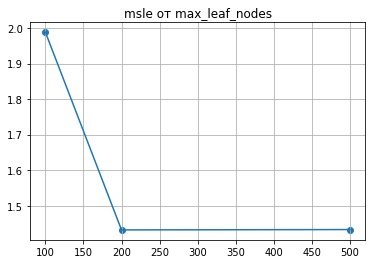

In [45]:
np.random.seed(1)
MSLE_leaf_nodes_train = {}
MSLE_leaf_nodes_test = {}
pipe.set_params(decision_tree__max_depth = None, decision_tree__min_samples_split=2, decision_tree__min_impurity_decrease=0.0, decision_tree__max_leaf_nodes=None)   
for d in max_leaf_nodes_list:
    pipe.set_params(decision_tree__max_leaf_nodes=d)
    pipe.fit(X_train, y_train)
    train_preds = pipe.predict(X_train)
    test_preds = pipe.predict(X_test)

    train_error = np.mean((train_preds - y_train)**2)
    test_error = np.mean((test_preds - y_test)**2)
    MSLE_leaf_nodes_train[d] = np.round(train_error, 3)
    MSLE_leaf_nodes_test[d] = np.round(test_error, 3)

print(min(MSLE_leaf_nodes_test.values()))
plt.grid(True)
plt.title('msle от max_leaf_nodes')
plt.scatter(MSLE_leaf_nodes_test.keys(), MSLE_leaf_nodes_test.values());
plt.plot(MSLE_leaf_nodes_test.keys(), MSLE_leaf_nodes_test.values());

Подберите лучшую комбинацию параметров, используя `GridSearchCV` и набор массивов значений параметров из предыдущего задания. Для лучшей комбинации посчитайте MSLE на тестовой выборке. Получились ли лучшие параметры такими же, как если бы вы подбирали их по-отдельности при остальных гиперпараметрах по умолчанию (предыдущее задание)? (2б)

In [46]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "decision_tree__max_depth": [3, 5, 8, 12],
    "decision_tree__min_samples_split": [10, 50, 100, 500],
    "decision_tree__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "decision_tree__max_leaf_nodes": [100, 200, 500]
}
np.random.seed(1)

### Your code is here

search = GridSearchCV(pipe, 
                      param_grid, 
                      cv=5,
                      scoring='neg_mean_squared_error',
                      verbose=10)

search.fit(X_train, y_train)

print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {search.score(X_test, y_test)}")



Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV 1/5; 1/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 1/5; 1/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-1.041 total time=   0.1s
[CV 2/5; 1/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 2/5; 1/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-0.832 total time=   0.0s
[CV 3/5; 1/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 3/5; 1/192] END decision_tree__max_depth=3, decision_tree__max_l

[CV 1/5; 6/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50;, score=-0.634 total time=   0.1s
[CV 2/5; 6/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50
[CV 2/5; 6/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50;, score=-0.498 total time=   0.0s
[CV 3/5; 6/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50
[CV 3/5; 6/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50;, score=-0.596 total time=   0.0s
[CV 4/5; 6/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, deci

[CV 1/5; 11/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.633 total time=   0.1s
[CV 2/5; 11/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100
[CV 2/5; 11/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.498 total time=   0.0s
[CV 3/5; 11/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100
[CV 3/5; 11/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.595 total time=   0.0s
[CV 4/5; 11/192] START decision_tree__max_depth=3, decision_tree__max_leaf

[CV 5/5; 15/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100;, score=-0.541 total time=   0.0s
[CV 1/5; 16/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500
[CV 1/5; 16/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.633 total time=   0.0s
[CV 2/5; 16/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500
[CV 2/5; 16/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.498 total time=   0.0s
[CV 3/5; 16/192] START decision_tree__max_depth=3, decision_tree__max_leaf_node

[CV 5/5; 20/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500;, score=-0.646 total time=   0.1s
[CV 1/5; 21/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10
[CV 1/5; 21/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.634 total time=   0.1s
[CV 2/5; 21/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10
[CV 2/5; 21/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.498 total time=   0.1s
[CV 3/5; 21/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200,

[CV 5/5; 25/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.541 total time=   0.1s
[CV 1/5; 26/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50
[CV 1/5; 26/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50;, score=-0.634 total time=   0.1s
[CV 2/5; 26/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50
[CV 2/5; 26/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50;, score=-0.498 total time=   0.2s
[CV 3/5; 26/192] START decision_tree__max_depth=3, decision_tree__max_leaf_node

[CV 3/5; 30/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.599 total time=   0.1s
[CV 4/5; 30/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50
[CV 4/5; 30/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.591 total time=   0.0s
[CV 5/5; 30/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50
[CV 5/5; 30/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.541 total time=   0.1s
[CV 1/5; 31/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=200

[CV 2/5; 35/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-0.823 total time=   0.1s
[CV 3/5; 35/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100
[CV 3/5; 35/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.049 total time=   0.0s
[CV 4/5; 35/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100
[CV 4/5; 35/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.033 total time=   0.1s
[CV 5/5; 35/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, dec

[CV 5/5; 39/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100;, score=-0.542 total time=   0.3s
[CV 1/5; 40/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500
[CV 1/5; 40/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500;, score=-0.634 total time=   0.3s
[CV 2/5; 40/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500
[CV 2/5; 40/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500;, score=-0.498 total time=   0.1s
[CV 3/5; 40/192] START decision_tree__max_depth=3, decision_tree__max_leaf_node

[CV 4/5; 44/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500;, score=-0.591 total time=   0.1s
[CV 5/5; 44/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500
[CV 5/5; 44/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500;, score=-0.541 total time=   0.1s
[CV 1/5; 45/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10
[CV 1/5; 45/192] END decision_tree__max_depth=3, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.634 total time=   0.1s
[CV 2/5; 45/192] START decision_tree__max_depth=3, decision_tree__max_leaf_nod

[CV 3/5; 49/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-1.935 total time=   0.2s
[CV 4/5; 49/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 4/5; 49/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-1.856 total time=   0.1s
[CV 5/5; 49/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 5/5; 49/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-1.542 total time=   0.1s
[CV 1/5; 50/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision

[CV 2/5; 54/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50;, score=-0.498 total time=   0.1s
[CV 3/5; 54/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50
[CV 3/5; 54/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50;, score=-0.598 total time=   0.1s
[CV 4/5; 54/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50
[CV 4/5; 54/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50;, score=-0.591 total time=   0.1s
[CV 5/5; 54/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100

[CV 1/5; 59/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.635 total time=   0.1s
[CV 2/5; 59/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100
[CV 2/5; 59/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.498 total time=   0.1s
[CV 3/5; 59/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100
[CV 3/5; 59/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.595 total time=   0.1s
[CV 4/5; 59/192] START decision_tree__max_depth=5, decision_tree__max_leaf

[CV 4/5; 63/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100;, score=-0.591 total time=   0.2s
[CV 5/5; 63/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100
[CV 5/5; 63/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100;, score=-0.542 total time=   0.1s
[CV 1/5; 64/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500
[CV 1/5; 64/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.634 total time=   0.1s
[CV 2/5; 64/192] START decision_tree__max_depth=5, decision_tree__max_leaf_node

[CV 3/5; 68/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500;, score=-0.799 total time=   0.1s
[CV 4/5; 68/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500
[CV 4/5; 68/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500;, score=-0.763 total time=   0.2s
[CV 5/5; 68/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500
[CV 5/5; 68/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500;, score=-0.642 total time=   0.1s
[CV 1/5; 69/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, dec

[CV 1/5; 73/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.634 total time=   0.1s
[CV 2/5; 73/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10
[CV 2/5; 73/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.498 total time=   0.2s
[CV 3/5; 73/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10
[CV 3/5; 73/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.596 total time=   0.1s
[CV 4/5; 73/192] START decision_tree__max_depth=5, decision_tree__max_leaf_node

[CV 4/5; 77/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.591 total time=   0.1s
[CV 5/5; 77/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10
[CV 5/5; 77/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.542 total time=   0.1s
[CV 1/5; 78/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50
[CV 1/5; 78/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.633 total time=   0.1s
[CV 2/5; 78/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=200

[CV 2/5; 82/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-1.023 total time=   0.2s
[CV 3/5; 82/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50
[CV 3/5; 82/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-1.934 total time=   0.1s
[CV 4/5; 82/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50
[CV 4/5; 82/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-1.312 total time=   0.2s
[CV 5/5; 82/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision

[CV 2/5; 87/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100;, score=-0.498 total time=   0.1s
[CV 3/5; 87/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100
[CV 3/5; 87/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100;, score=-0.603 total time=   0.1s
[CV 4/5; 87/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100
[CV 4/5; 87/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100;, score=-0.591 total time=   0.1s
[CV 5/5; 87/192] START decision_tree__max_depth=5, decision_tree__max_leaf_node

[CV 5/5; 91/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.541 total time=   0.1s
[CV 1/5; 92/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500
[CV 1/5; 92/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500;, score=-0.633 total time=   0.2s
[CV 2/5; 92/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500
[CV 2/5; 92/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500;, score=-0.498 total time=   0.3s
[CV 3/5; 92/192] START decision_tree__max_depth=5, decision_tree__max_leaf

[CV 3/5; 96/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.595 total time=   0.2s
[CV 4/5; 96/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500
[CV 4/5; 96/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.591 total time=   0.1s
[CV 5/5; 96/192] START decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500
[CV 5/5; 96/192] END decision_tree__max_depth=5, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.541 total time=   0.3s
[CV 1/5; 97/192] START decision_tree__max_depth=8, decision_tree__max_leaf_node

[CV 1/5; 101/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.633 total time=   0.1s
[CV 2/5; 101/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10
[CV 2/5; 101/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.498 total time=   0.1s
[CV 3/5; 101/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10
[CV 3/5; 101/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.595 total time=   0.1s
[CV 4/5; 101/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nod

[CV 5/5; 105/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.538 total time=   0.1s
[CV 1/5; 106/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50
[CV 1/5; 106/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50;, score=-0.633 total time=   0.1s
[CV 2/5; 106/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50
[CV 2/5; 106/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50;, score=-0.498 total time=   0.1s
[CV 3/5; 106/192] START decision_tree__max_depth=8, decision_tree__max_lea

[CV 5/5; 110/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.541 total time=   0.1s
[CV 1/5; 111/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100
[CV 1/5; 111/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100;, score=-0.635 total time=   0.1s
[CV 2/5; 111/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100
[CV 2/5; 111/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100;, score=-0.498 total time=   0.1s
[CV 3/5; 111/192] START decision_tree__max_depth=8, decision_tree__max_leaf

[CV 3/5; 115/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.241 total time=   0.1s
[CV 4/5; 115/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100
[CV 4/5; 115/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.308 total time=   0.1s
[CV 5/5; 115/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100
[CV 5/5; 115/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.047 total time=   0.1s
[CV 1/5; 116/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=20

[CV 2/5; 120/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500;, score=-0.498 total time=   0.1s
[CV 3/5; 120/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500
[CV 3/5; 120/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500;, score=-0.602 total time=   0.1s
[CV 4/5; 120/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500
[CV 4/5; 120/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500;, score=-0.591 total time=   0.1s
[CV 5/5; 120/192] START decision_tree__max_depth=8, decision_tree__max_lea

[CV 2/5; 125/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.498 total time=   0.1s
[CV 3/5; 125/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10
[CV 3/5; 125/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.596 total time=   0.1s
[CV 4/5; 125/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10
[CV 4/5; 125/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.591 total time=   0.1s
[CV 5/5; 125/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nod

[CV 1/5; 130/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-1.470 total time=   0.1s
[CV 2/5; 130/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50
[CV 2/5; 130/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-1.021 total time=   0.1s
[CV 3/5; 130/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50
[CV 3/5; 130/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=50;, score=-1.928 total time=   0.1s
[CV 4/5; 130/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, de

[CV 4/5; 134/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50;, score=-0.591 total time=   0.1s
[CV 5/5; 134/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50
[CV 5/5; 134/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=50;, score=-0.538 total time=   0.1s
[CV 1/5; 135/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100
[CV 1/5; 135/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=100;, score=-0.634 total time=   0.1s
[CV 2/5; 135/192] START decision_tree__max_depth=8, decision_tree__max_leaf_n

[CV 4/5; 139/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.591 total time=   0.1s
[CV 5/5; 139/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100
[CV 5/5; 139/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=100;, score=-0.538 total time=   0.1s
[CV 1/5; 140/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500
[CV 1/5; 140/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=500;, score=-0.634 total time=   0.1s
[CV 2/5; 140/192] START decision_tree__max_depth=8, decision_tree__ma

[CV 4/5; 144/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.591 total time=   0.1s
[CV 5/5; 144/192] START decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500
[CV 5/5; 144/192] END decision_tree__max_depth=8, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.541 total time=   0.1s
[CV 1/5; 145/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10
[CV 1/5; 145/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=10;, score=-1.725 total time=   0.1s
[CV 2/5; 145/192] START decision_tree__max_depth=12, decision_tree__max_leaf_n

[CV 3/5; 149/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.595 total time=   0.1s
[CV 4/5; 149/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10
[CV 4/5; 149/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.591 total time=   0.1s
[CV 5/5; 149/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10
[CV 5/5; 149/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=10;, score=-0.538 total time=   0.1s
[CV 1/5; 150/192] START decision_tree__max_depth=12, decision_tree__max_le

[CV 3/5; 154/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50;, score=-0.595 total time=   0.1s
[CV 4/5; 154/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50
[CV 4/5; 154/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50;, score=-0.591 total time=   0.1s
[CV 5/5; 154/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50
[CV 5/5; 154/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=50;, score=-0.538 total time=   0.1s
[CV 1/5; 155/192] START decision_tree__max_depth=12, decision_tree__m

[CV 4/5; 159/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100;, score=-0.591 total time=   0.1s
[CV 5/5; 159/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100
[CV 5/5; 159/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=100;, score=-0.542 total time=   0.1s
[CV 1/5; 160/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500
[CV 1/5; 160/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=100, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=500;, score=-0.634 total time=   0.1s
[CV 2/5; 160/192] START decision_tree__max_depth=12, decision_tree__m

[CV 2/5; 164/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500;, score=-0.600 total time=   0.1s
[CV 3/5; 164/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500
[CV 3/5; 164/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500;, score=-0.800 total time=   0.1s
[CV 4/5; 164/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500
[CV 4/5; 164/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=500;, score=-0.762 total time=   0.1s
[CV 5/5; 164/192] START decision_tree__max_depth=12, decision_tree__max_leaf_no

[CV 1/5; 169/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.635 total time=   0.0s
[CV 2/5; 169/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10
[CV 2/5; 169/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.498 total time=   0.0s
[CV 3/5; 169/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10
[CV 3/5; 169/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.15, decision_tree__min_samples_split=10;, score=-0.596 total time=   0.0s
[CV 4/5; 169/192] START decision_tree__max_depth=12, decision_tree__m

[CV 1/5; 174/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.633 total time=   0.1s
[CV 2/5; 174/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50
[CV 2/5; 174/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.498 total time=   0.1s
[CV 3/5; 174/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50
[CV 3/5; 174/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=200, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=50;, score=-0.595 total time=   0.1s
[CV 4/5; 174/192] START decision_tree__max_depth=12, decision_tree__max_le

[CV 1/5; 179/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.261 total time=   0.1s
[CV 2/5; 179/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100
[CV 2/5; 179/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.022 total time=   0.1s
[CV 3/5; 179/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100
[CV 3/5; 179/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0, decision_tree__min_samples_split=100;, score=-1.241 total time=   0.1s
[CV 4/5; 179/192] START decision_tree__max_depth=12, decision_tree__max_leaf_no

[CV 3/5; 184/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500;, score=-0.598 total time=   0.1s
[CV 4/5; 184/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500
[CV 4/5; 184/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500;, score=-0.591 total time=   0.0s
[CV 5/5; 184/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500
[CV 5/5; 184/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.1, decision_tree__min_samples_split=500;, score=-0.541 total time=   0.1s
[CV 1/5; 185/192] START decision_tree__max_depth=12, decision_tree__m

[CV 1/5; 189/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.635 total time=   0.1s
[CV 2/5; 189/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10
[CV 2/5; 189/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.498 total time=   0.1s
[CV 3/5; 189/192] START decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10
[CV 3/5; 189/192] END decision_tree__max_depth=12, decision_tree__max_leaf_nodes=500, decision_tree__min_impurity_decrease=0.2, decision_tree__min_samples_split=10;, score=-0.600 total time=   0.1s
[CV 4/5; 189/192] START decision_tree__max_depth=12, decision_tree__max_le

In [47]:
print(f"Качество лучшей модели на финальном тесте: {search.score(X_test, y_test):0.3f}")
#{num:0.3f}

Качество лучшей модели на финальном тесте: -0.520
